# LiberTEM UDFs

In [1]:
%matplotlib nbagg

In [2]:
import matplotlib.pyplot as plt
import libertem.api as lt
import numpy as np

In [3]:
ctx = lt.Context()

## Specifying the dataset

Most formats can be loaded using the `"auto"` type, but some may need additional parameters.

See the [loading data](https://libertem.github.io/LiberTEM/formats.html) section of the LiberTEM docs for details.

In [4]:
ds = ctx.load("auto", path="/home/alex/Data/01_ms1_3p3gK.hdr")

After loading, some information is available in the `diagnostics` attribute:

In [5]:
ds.diagnostics

[{'name': 'Data type', 'value': 'u16'},
 {'name': 'Partition shape', 'value': '(2075, 256, 256)'},
 {'name': 'Number of partitions', 'value': '33'}]

# Standard analyses: virtual detector

A standard analysis to run on 4D STEM data is to apply a virtual detector. Here, we define a ring detector:

In [6]:
ring = ctx.create_ring_analysis(dataset=ds, ri=60, ro=70)

The analysis can be run with the `Context.run` method:

In [7]:
ring_res = ctx.run(ring, progress=True)
ring_res

100%|██████████| 33/33 [00:10<00:00,  3.07it/s]


[<AnalysisResult: intensity>]

As the analysis mirrors what the web GUI does, we have to access the data using the `raw_data` attribute, as we would get a viusalized result otherwise. Here we do the visualization ourselves using `matplotlib`:

<IPython.core.display.Javascript object>


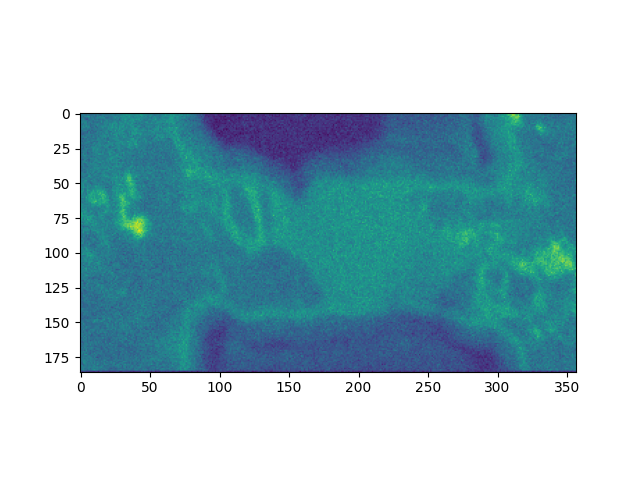

In [8]:
plt.figure()
plt.imshow(ring_res.intensity.raw_data)

## Simple UDF definition

User-defined funtions provide a way for you to implement your own data processing functionality. As a very simple example, we define a function that just sums up the pixels of each frame:

In [9]:
def sum_of_pixels(frame):
    return np.sum(frame)

The easiest way to run this on the data is to use the `Context.map` function:

In [10]:
res_pixelsum_1 = ctx.map(dataset=ds, f=sum_of_pixels, progress=True)
res_pixelsum_1

100%|██████████| 33/33 [00:02<00:00, 11.13it/s]


<BufferWrapper kind=nav dtype=uint64 extra_shape=()>

The result is of type `BufferWrapper`, but can be used by any function that expects a numpy array, for example for plotting it:

<IPython.core.display.Javascript object>


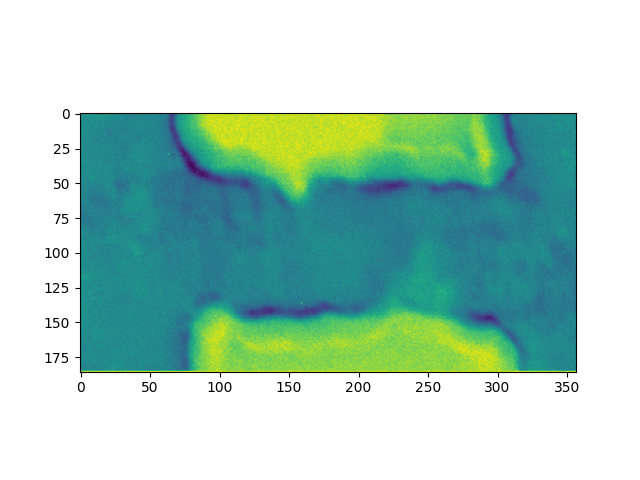

In [11]:
plt.figure()
plt.imshow(res_pixelsum_1)

The `Context.map` function is a shortcut for implementing very easy mapping over data, in a frame-by-frame fashion. The longer way of writing this would be as follows:

In [12]:
from libertem.udf import UDF


class SumOfPixels(UDF):
    def get_result_buffers(self):
        return {
            'sum_of_pixels': self.buffer(kind='nav', dtype='float32')
        }
    
    def process_frame(self, frame):
        self.results.sum_of_pixels[:] = np.sum(frame)

This can now be run using the `Context.run_udf` method:

In [13]:
res_pixelsum_2 = ctx.run_udf(dataset=ds, udf=SumOfPixels(), progress=True)
res_pixelsum_2

100%|██████████| 33/33 [00:02<00:00, 11.84it/s]


{'sum_of_pixels': <BufferWrapper kind=nav dtype=float32 extra_shape=()>}

The result is now a `dict`, which maps buffer names, as defined in `get_result_buffers`, to the `BufferWrapper` result, so we can use the following to plot the results:

<IPython.core.display.Javascript object>


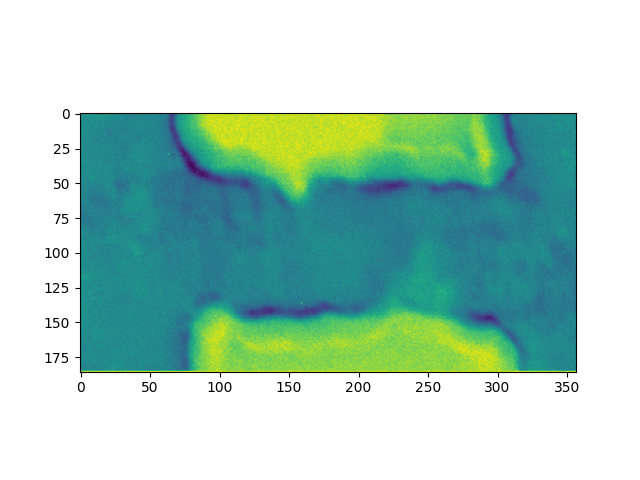

In [14]:
plt.figure()
plt.imshow(res_pixelsum_2['sum_of_pixels'])

## `extra_shape`: more than one result per scan position

In [15]:
class StatsUDF(UDF):
    def get_result_buffers(self):
        return {
            'all_stats': self.buffer(kind='nav', dtype='float32', extra_shape=(4,)),
        }
    
    def process_frame(self, frame):
        self.results.all_stats[:] = (np.mean(frame), np.min(frame), np.max(frame), np.std(frame))

In [16]:
res_stats = ctx.run_udf(dataset=ds, udf=StatsUDF(), progress=True)

100%|██████████| 33/33 [00:07<00:00,  4.69it/s]


Result now has an extra dimension, as specified by `extra_shape` above:

In [17]:
res_stats['all_stats'].data.shape

(186, 357, 4)

Let's plot the `stddev` of each frame:

<IPython.core.display.Javascript object>


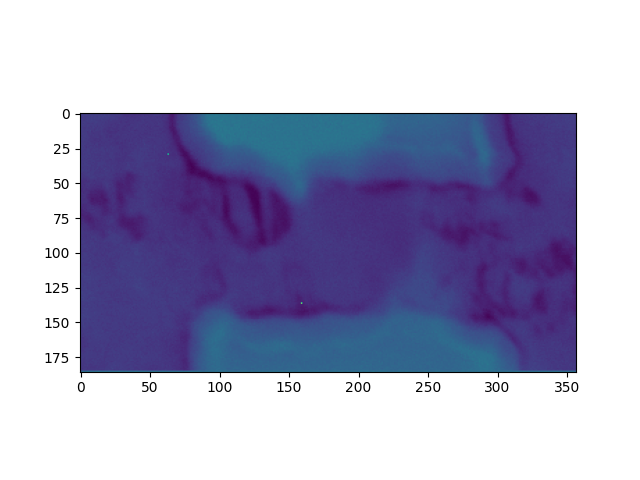

In [18]:
plt.figure()
plt.imshow(res_stats['all_stats'].data[..., 3])

## kind="sig" buffers, merge functions
- Previously: one result for each scan position
- Now: result buffer shaped like the diffraction patterns
- We need a merge function to merge the result of one partition into the final result

In [19]:
class MaxFrameUDF(UDF):
    def get_result_buffers(self):
        return {
            'maxframe': self.buffer(kind='sig', dtype='float32')
        }
    
    def process_frame(self, frame):
        # element-wise maximum:
        self.results.maxframe[:] = np.maximum(self.results.maxframe, frame)

    def merge(self, dest, src):
        # src: the maximum observed in the current partition
        # dest: the maximum observed in all partitions that were already merged together
        dest['maxframe'][:] = np.maximum(dest['maxframe'], src['maxframe'])

In [20]:
res_max = ctx.run_udf(dataset=ds, udf=MaxFrameUDF(), progress=True)

100%|██████████| 33/33 [00:03<00:00,  8.42it/s]


<IPython.core.display.Javascript object>


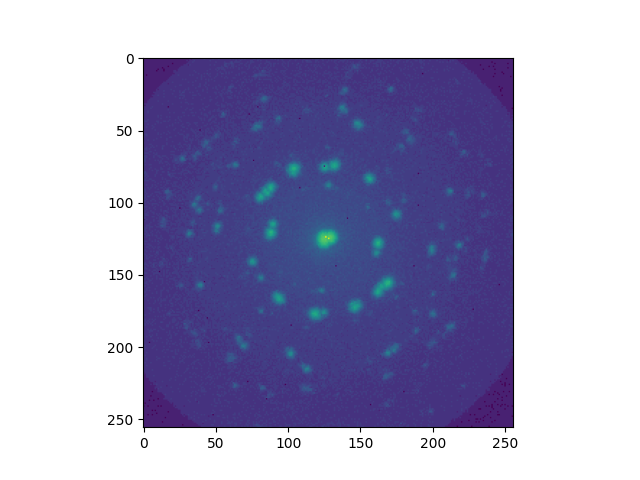

In [21]:
plt.figure()
plt.imshow(np.log1p(res_max['maxframe']))

# Region of interest

- work on a subset of diffraction patterns
- useful for working selectively on data, or just reducing the computation when implementing a new UDF
- defined as a binary mask

Let's create a mask based on the previously calculated pixel-sum:

In [22]:
from skimage.morphology import opening, closing

In [23]:
np.min(res_pixelsum_1),  np.max(res_pixelsum_1), np.mean(res_pixelsum_1)

(7762, 12367, 10277.384702268004)

<IPython.core.display.Javascript object>


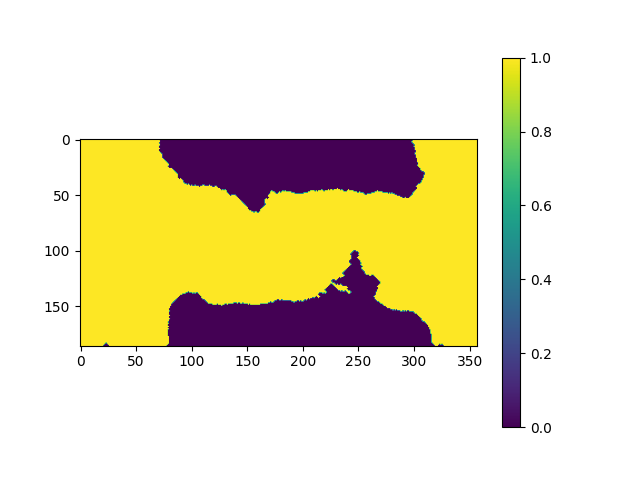

In [24]:
mask = res_pixelsum_1.data < np.mean(res_pixelsum_1)
# mask = opening(mask)
mask = closing(opening(mask))

plt.figure()
plt.imshow(mask.astype("float32"))
plt.colorbar()

In [25]:
res_roi = ctx.run_udf(dataset=ds, udf=SumOfPixels(), roi=mask, progress=True)

100%|██████████| 33/33 [00:06<00:00,  4.97it/s]


<IPython.core.display.Javascript object>


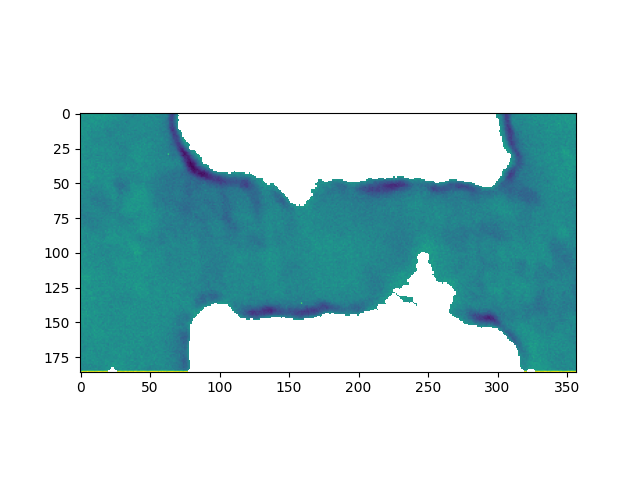

In [26]:
plt.figure()
plt.imshow(res_roi['sum_of_pixels'])

One has to take some care when handling results where a `roi` was applied; just using the result as a numpy array or accessing the `data` attribute will give you a result that keeps the whole dataset shape, where the deselected parts are filled with `NaN` values:

In [27]:
res_roi['sum_of_pixels'].data.shape

(186, 357)

There is a second attribute, `raw_data`, which will give you a flat array of just the results, like numpy would give you for fancy indexing:

In [28]:
res_roi['sum_of_pixels'].raw_data.shape

(45358,)

# Extra: mask-based analyses

These can be used to create arbitrary virtual detector shapes, and apply all of them to the data at once:

In [29]:
mask_analysis = ctx.create_mask_analysis(dataset=ds, factories=[lambda: np.ones((256, 256))])

In [32]:
res_mask = ctx.run(mask_analysis, progress=True)

100%|██████████| 33/33 [00:04<00:00,  6.70it/s]


<IPython.core.display.Javascript object>


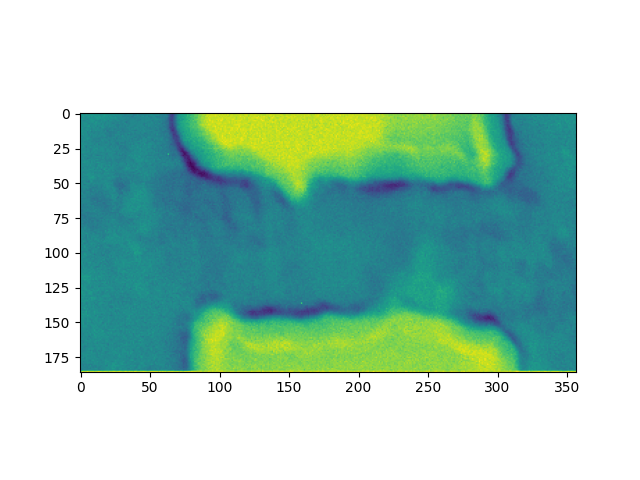

In [31]:
plt.figure()
plt.imshow(res_mask[0].raw_data)